In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import cv2
import os

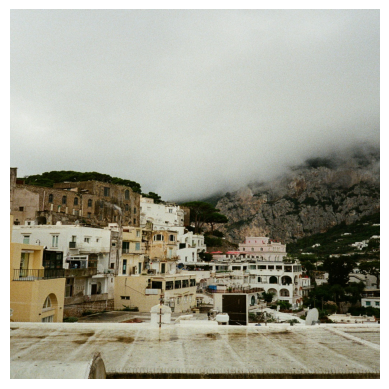

In [ ]:
builing = Image.open('buildings.jpg')
builing = np.array(builing)
plt.imshow(builing)
plt.axis('off')
plt.show()

In [9]:
builing.shape

(1024, 1024, 3)

In [57]:
M = 256
PI = np.pi

# Each needs its own copy
x1 = np.zeros((M, M))
x2 = np.zeros((M, M))
x3 = np.zeros((M, M))

# Horizontal sinusoid
for m in range(M):
    x1[m, :] = np.sin(PI * m * 24 / M)

# Vertical sinusoid
for n in range(M):
    x2[:, n] = np.sin(PI * n * 16 / M)

# Diagonal sinusoid
for m in range(M):
    for n in range(M):
        x3[m, n] = np.sin(2 * PI * (6 * m + 10 * n) / M)

# Combine
x = np.mean([x1, x2, x3], axis=0)


In [82]:
DFT = np.fft.fftshift(np.fft.fft2(x))
DFT_abs = np.abs(DFT)
# full_scale = (DFT_abs-np.min(DFT_abs))/(np.max(DFT_abs) - np.min(DFT_abs))
# full_scale = full_scale.astype(np.uint8)
# full_scale = np.log(1 + full_scale**0.001)
DFT_log = np.log(1 + DFT_abs**0.001)

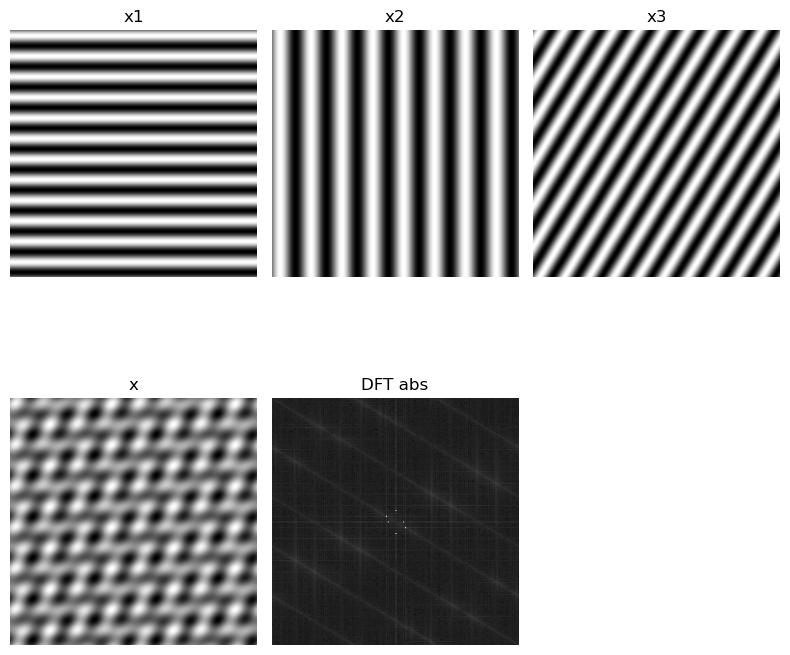

In [83]:
plt.figure(figsize=(8,8))
plt.subplot(2,3,1)
plt.imshow(x1,cmap='gray')
plt.title('x1')
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(x2,cmap='gray')
plt.title('x2')
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(x3,cmap='gray')
plt.title('x3')
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(x,cmap='gray')
plt.title('x')
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(DFT_log,cmap='gray')
plt.title('DFT abs')
plt.axis('off')

plt.tight_layout()
plt.show()

### (b) Design directional filters of size M ×M

In [115]:
def directional_filter(M, W1,W2):
    """
    Create a directional filter of size MxM with passband between angles W1 and W2 (in degrees).
    """
    # Convert angles from degrees to radians
    W1 = np.deg2rad(W1)
    W2 = np.deg2rad(W2)

    # Create a grid of (u,v) coordinates
    u = np.arange(-M//2, M//2)
    v = np.arange(-M//2, M//2)
    U, V = np.meshgrid(u, v) # Create a grid of (u,v) coordinates (M x M)

    # Calculate the angle of each point in the frequency domain
    angle = np.arctan2(V, U) # Angle in radians

    # Create the directional filter
    D = np.zeros((M, M))
    #If the angle is within the bandwidth, set to 1
    if W1 < W2:
        D[(angle >= W1) & (angle <= W2)] = 1
    else: 
        D[(angle >= W1) | (angle <= W2)] = 1
    return D.astype(np.uint8)

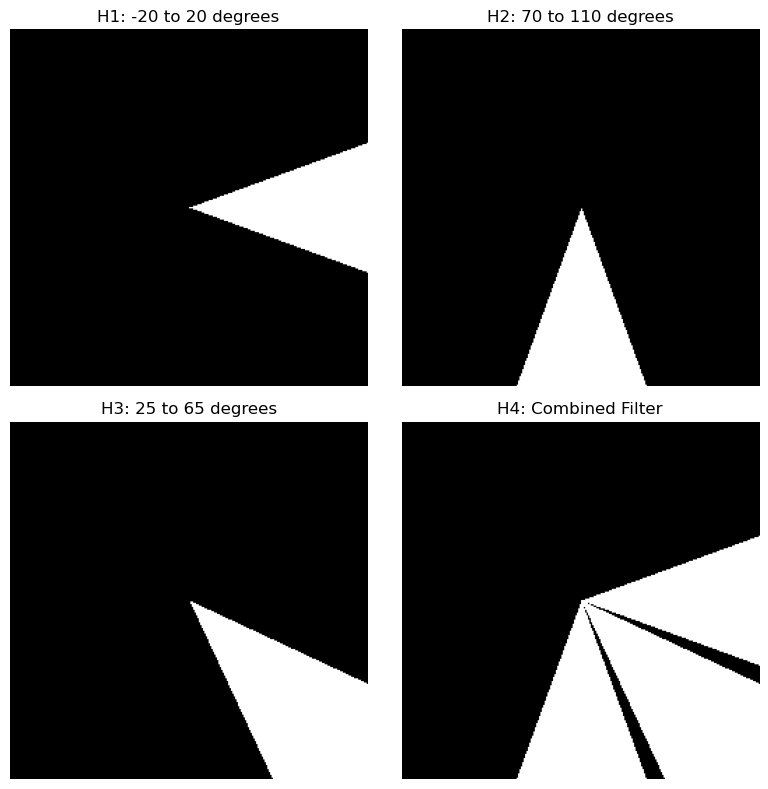

In [ ]:
H1 = directional_filter(M, -20, 20)
H2 = directional_filter(M, 70, 110)
H3 = directional_filter(M, 25, 65)
H4 = H1 + H2 + H3
H4[H4 > 1] = 1  #Elementwise maximum value of 1
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(H1, cmap='gray')
plt.title('H1: -20 to 20 degrees')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(H2, cmap='gray')
plt.title('H2: 70 to 110 degrees')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(H3, cmap='gray')
plt.title('H3: 25 to 65 degrees')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(H4, cmap='gray')
plt.title('H4: Combined Filter')
plt.axis('off')
plt.tight_layout()
plt.show()

### i. The original image.
### ii. The original image magnitude spectrum.
### iii. The directional filter magnitude spectrum.
### iv. The filtered magnitude spectrum.
### v. The reconstructed filtered image

In [146]:
def display_image(img1, img2, img3, img4, img5, filter_name=''):
    fig, axes = plt.subplots(2, 3, figsize=(9, 7))
    fig.suptitle(f'Directional Filtering using filter {filter_name}', fontsize=14, y=0.95)
    ax = axes.ravel()

    images = [img1, img2, img3, img4, img5]
    titles = [
        "Original Image",
        "Original Image Magnitude Spectrum",
        "Directional Filter Magnitude Spectrum",
        "Filtered Magnitude Spectrum",
        "Reconstructed Filtered Image"
    ]

    for i in range(len(images)):
        ax[i].imshow(images[i], cmap='gray')
        ax[i].set_title(titles[i], fontsize=10)
        ax[i].axis('off')

    # Hide the empty 6th subplot
    fig.delaxes(ax[5])

    # Make the layout tight and compact
    plt.subplots_adjust(
        left=0.03, right=0.97, top=0.90, bottom=0.03,
        wspace=0.1, hspace=0.15
    )

    plt.show()


In [167]:
def directional_filter_image(image,dir_filter):
    M, N = image.shape
    # Compute the 2D DFT of the image and shift the zero frequency component to the center
    DFT = np.fft.fftshift(np.fft.fft2(image))
    DFT_abs = np.abs(DFT)
    DFT_log = np.log(1 + DFT_abs**0.01)

    # Apply the directional filter in the frequency domain
    filtered_DFT = DFT * dir_filter
    filtered_DFT_abs = np.abs(filtered_DFT)
    filtered_DFT_log = np.log(1 + filtered_DFT_abs**0.05)
    #Filtered magnitude spectrum
    # filter_magnitude_spectrum = dir_filter
    # Reconstruct the filtered image using the inverse 2D DFT
    reconstructed_image = np.fft.ifft2(np.fft.ifftshift(filtered_DFT))
    reconstructed_image = np.abs(reconstructed_image)
    reconstructed_image = (reconstructed_image - np.min(reconstructed_image)) / (np.max(reconstructed_image) - np.min(reconstructed_image))
    
    return image, DFT_log,dir_filter, filtered_DFT_log, reconstructed_image

In [168]:
image = x
filters = [H1, H2, H3, H4]
reconstructed_images = []

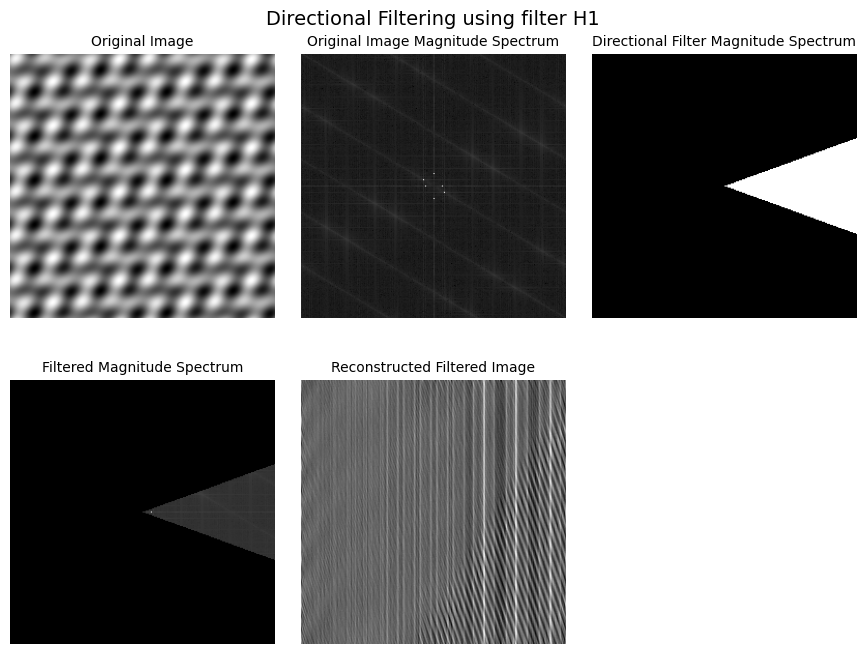

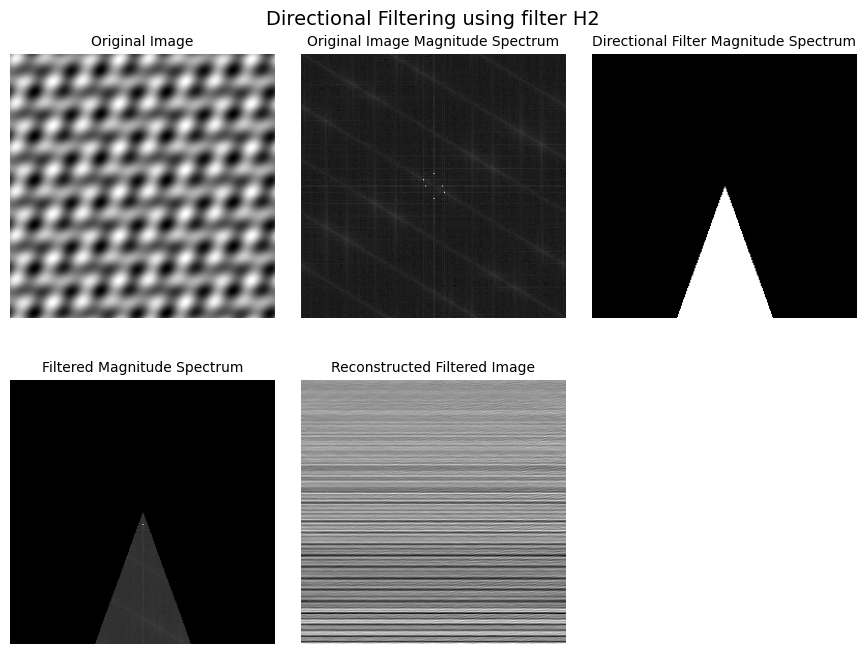

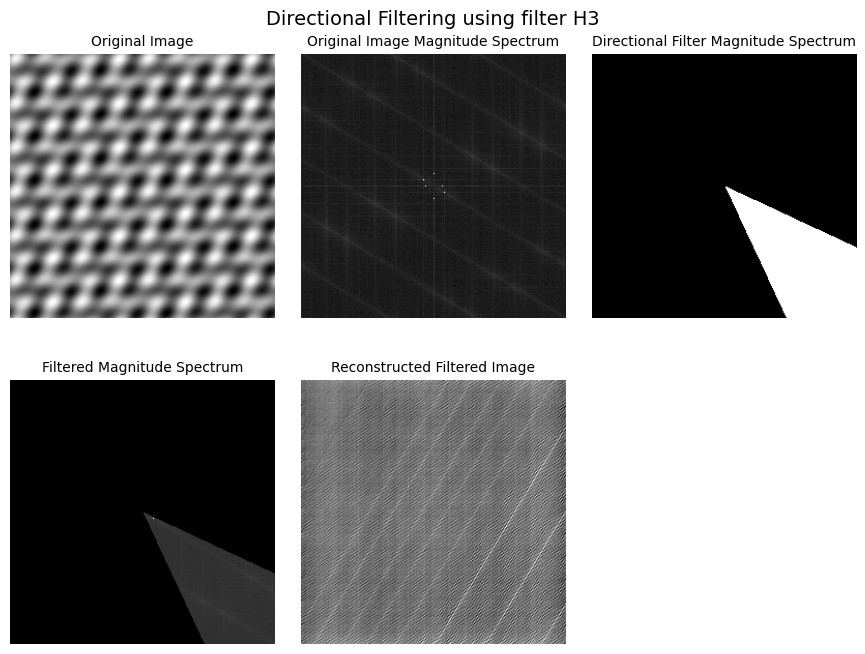

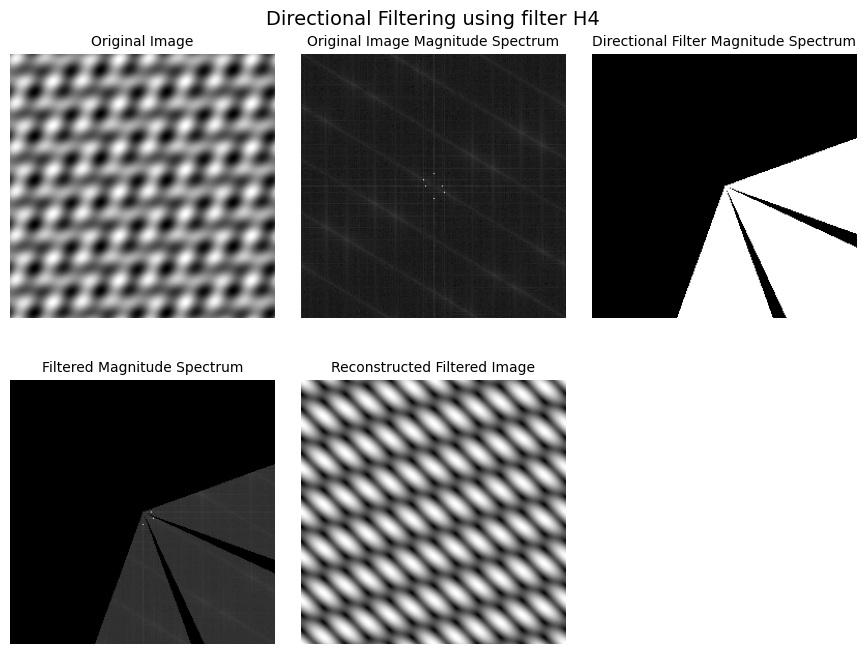

In [169]:
for i,filter in enumerate(filters):
    orig_img, orig_mag_spec, filter, filtered_mag_spec, recon_img = directional_filter_image(image, filter)
    reconstructed_images.append(recon_img)
    display_image(orig_img, orig_mag_spec, filter, filtered_mag_spec, recon_img, filter_name=(f'H{i+1}'))

In [170]:
mse = []
for recon_img in reconstructed_images:
    error = np.mean((image - recon_img) ** 2)
    mse.append(error)

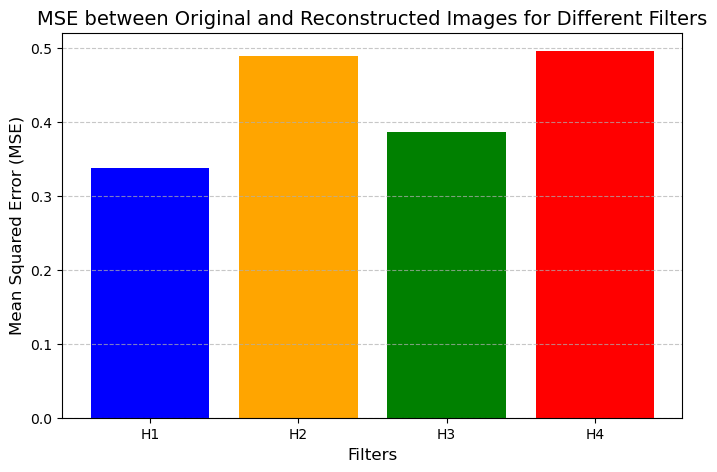

In [178]:
plt.figure(figsize=(8,5))
plt.bar(['H1', 'H2', 'H3', 'H4'], mse, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Filters', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('MSE between Original and Reconstructed Images for Different Filters', fontdict={'fontsize': 14})
plt.show()